1. Preprocessor:    
    - Filtering
    - Augmentation in time domain
(still in dataframe)

2. Compression
    - Store the data in less bits (currently in 16bit)

In [3]:
# given
import struct
from pathlib import Path
# import RaggedArray type


BASE_DIR = Path().resolve()
data_path = BASE_DIR / "data"  # Directory to store data files
train_data_path = BASE_DIR / "data" / "X_train.bin"
test_data_path = BASE_DIR / "data" / "X_test.bin"
train_label_path = BASE_DIR / "data" / "y_train.csv"


def read_binary(path):
    ragged_array = []
    with open(path, "rb") as r:
        read_binary_from(ragged_array, r)
    return ragged_array


def read_binary_from(ragged_array, r):
    while True:
        size_bytes = r.read(4)
        if not size_bytes:
            break
        sub_array_size = struct.unpack("i", size_bytes)[0]
        sub_array = list(
            struct.unpack(f"{sub_array_size}h", r.read(sub_array_size * 2))
        )
        sub_array = [int(x) for x in sub_array]
        ragged_array.append(sub_array)

In [ ]:
# find a lossless compression type for the data instead of 16bit (e.g., PDICT, PDELTA, PFOR).  --> then NS (null suppression)
from dask import delayed, compute
import numpy as np
import bitstruct
import struct
from pathlib import Path


def pack_offsets(offsets, bits_needed=12):
    fmt = f"u{bits_needed}"
    overall_fmt = fmt * len(offsets)
    packed = bitstruct.pack(overall_fmt, *offsets)
    return packed


def unpack_offsets(packed, bits_needed=12, num_values=None):
    fmt = f"u{bits_needed}"
    if num_values is None:
        raise ValueError("num_values must be provided")
    overall_fmt = fmt * num_values
    unpacked = bitstruct.unpack(overall_fmt, packed)
    return list(unpacked)


def for_encode(data: list) -> tuple:
    data_copy = data.copy()
    min_val = min(data)
    for i in range(len(data_copy)):
        data_copy[i] -= min_val
        if data_copy[i] < 0:
            print(f"data[i] is negative: {data_copy[i]} min_val: {min_val}")
    return min_val, data_copy


def for_decode(data: list, min_val: int) -> list:
    return [val + min_val for val in data]


@delayed
def process_patch(patch):
    min_val, encoded_patch = for_encode(patch)
    max_val = max(encoded_patch) if encoded_patch else 0
    return encoded_patch, min_val, max_val


def pfor_encode(data: list, patch_size: int = 128) -> tuple:
    patch_tasks = []
    for i in range(0, len(data), patch_size):
        patch = data[i : i + patch_size]
        patch_tasks.append(process_patch(patch))

    results = compute(*patch_tasks)

    patches = []
    min_vals = []
    max_all = 0
    bits_needed = 0

    for encoded_patch, min_val, max_val in results:
        patches.append(encoded_patch)
        min_vals.append(min_val)

        if max_val > max_all:
            bits_needed = max_val.bit_length() if max_val > 0 else 1
            max_all = max_val

    return patches, min_vals, bits_needed


def encoded_pfor_to_binary(signal_length, patches, min_vals, bits_needed=12) -> bytes:
    # first 32 bits for the length of the signal
    # second 32 bits for the bits needed
    # third 32 bits for the patch size

    patch_size = len(patches[0]) if patches else 0  
    header = struct.pack("III", signal_length, bits_needed, patch_size)
    # last patch length and num_patches can be inferred from the header data

    packed_patches = bytearray(header)
    for min_val, patch in zip(min_vals, patches):
        packed_patches.extend(struct.pack("h", min_val))
        packed_offsets = pack_offsets(patch, bits_needed)
        packed_patches.extend(packed_offsets)

    return bytes(packed_patches)


@delayed
def signal_to_binary_delayed(signal, patch_size) -> tuple:
    signal_length = len(signal)
    patches, min_vals, bits_needed = pfor_encode(signal, patch_size)
    return (
        encoded_pfor_to_binary(signal_length, patches, min_vals, bits_needed),
        bits_needed,
    )


# single signal for completeness
def signal_to_binary(signal, patch_size) -> tuple:
    binary_data, bits_needed = signal_to_binary_delayed(signal, patch_size).compute()
    print(f"bits needed for this signal {bits_needed}")
    return binary_data, bits_needed


def signals_to_binary(signals, patch_size) -> tuple:
    # header: # first 32 bits for the number of signals
    num_signals = len(signals)
    header = struct.pack("I", num_signals)

    signal_tasks = [signal_to_binary_delayed(signal, patch_size) for signal in signals]

    results = compute(*signal_tasks)
    binary_data = bytearray(header)
    for result in results:
        binary_data.extend(result[0])
    bits_needed = results[0][1] if results else 0
    return bytes(binary_data), bits_needed


def pfor_decode(patches) -> list:  
    decoded_data = []
    for min_val, patch in patches:
        decoded_patch = for_decode(patch, min_val)
        decoded_data.extend(decoded_patch)
    return decoded_data


def binary_to_decoded_pfor(binary_data: bytes, start_offset: int = 0) -> tuple:  
    header_size = 12  # 3 integers of 4 bytes each

    signal_length, bits_needed, patch_size = struct.unpack("III", binary_data[start_offset : start_offset + header_size])

    if patch_size == 0: 
        return [], header_size

    if signal_length == patch_size:
        num_patches = 1
    else:
        num_patches = (signal_length + patch_size - 1) // patch_size

    patches = []
    offset = start_offset + header_size

    for i in range(num_patches):
        min_val = struct.unpack("h", binary_data[offset : offset + 2])[0]
        offset += 2

        if i == num_patches - 1:
            num_values = signal_length - (num_patches - 1) * patch_size
            if num_values <= 0:
                raise ValueError("Invalid number of values in the last patch")
        else:
            num_values = patch_size

        patch_length = (num_values * bits_needed + 7) // 8
        packed_offsets = binary_data[offset : offset + patch_length]
        offsets = unpack_offsets(packed_offsets, bits_needed, num_values)
        offset += patch_length

        patches.append((min_val, offsets))

    decoded_data = pfor_decode(patches)
    bytes_consumed = offset - start_offset  # it's way easier this way
    return decoded_data, bytes_consumed


def binary_to_signals(binary_data: bytes) -> list:
    header_size = 4  # 1 integer of 4 bytes ---> just to signal when to stop, could be removed
    (num_signals,) = struct.unpack("I", binary_data[:header_size])
    offset = header_size
    signals = []

    for _ in range(num_signals):
        signal, bytes_consumed = binary_to_decoded_pfor(binary_data, offset)  
        signals.append(signal)
        offset += bytes_consumed  

    return signals


def test_roundtrip():

    original_signal = [100, 102, 105, 103, 108, 110, 107, 112]
    patch_size = 512
    binary, bits_needed = signal_to_binary(original_signal, patch_size)
    decoded_signal, _ = binary_to_decoded_pfor(binary)

    print(f"Original: {original_signal}")
    print(f"Decoded:  {decoded_signal}")
    print(f"Match: {original_signal == decoded_signal}")


    original_signals = [
        [i for i in range(rand_length)] for rand_length in range(2000, 9000, 500)
    ]


    with open("original_signals.bin", "wb") as f:
        for signal in original_signals:
            f.write(struct.pack("I", len(signal)))
            f.write(struct.pack(f"{len(signal)}h", *signal))


    original_signals_read = read_binary("original_signals.bin")
    assert original_signals_read == original_signals

    print(f"Size of original signals file: {Path('original_signals.bin').stat().st_size} bytes")

    binary, bits_needed = signals_to_binary(original_signals, patch_size)
    print(f"Size of binary {len(binary)} bytes")
    print(f"Bits needed: {bits_needed}")
    with open("encoded_signals.bin", "wb") as f:
        f.write(binary)

    print(f"Size of encoded signals file: {Path('encoded_signals.bin').stat().st_size} bytes")
    decoded_signals = binary_to_signals(binary)

    print(f"\nMultiple signals test:")
    print(f"Original: {original_signals}")
    print(f"Decoded:  {decoded_signals}")
    print(f"Match: {original_signals == decoded_signals}")


if __name__ == "__main__":
    test_roundtrip()

bits needed for this signal 4
Original: [100, 102, 105, 103, 108, 110, 107, 112]
Decoded:  [100, 102, 105, 103, 108, 110, 107, 112]
Match: True
Size of original signals file: 147056 bytes
Size of binary 83157 bytes
Bits needed: 9
Size of encoded signals file: 83157 bytes

Multiple signals test:
Original: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 16

In [ ]:
# test binary conversion
import pandas as pd

print(f"Size of original signals file: {train_data_path.stat().st_size} bytes")
signals = read_binary(train_data_path)  



binary, bits_used = signals_to_binary(signals, patch_size=512)

binary_length = len(binary)
print(f"Size of encoded signals file: {binary_length} bytes")
with open("encoded_signals.bin", "wb") as f:
    f.write(binary)

binary_file_size = Path("encoded_signals.bin").stat().st_size
print(f"Size of encoded signals file: {binary_file_size} bytes")
decoded_signals = binary_to_signals(binary)
print(f"Decoded signals length: {len(decoded_signals)}")
assert signals == decoded_signals, "Decoded signals do not match original"

compression_ratio = binary_length / train_data_path.stat().st_size
print(f"Compression ratio: {compression_ratio:.2f}")



Size of original signals file: 120641086 bytes
Size of encoded signals file: 85590101 bytes
Size of encoded signals file: 85590101 bytes


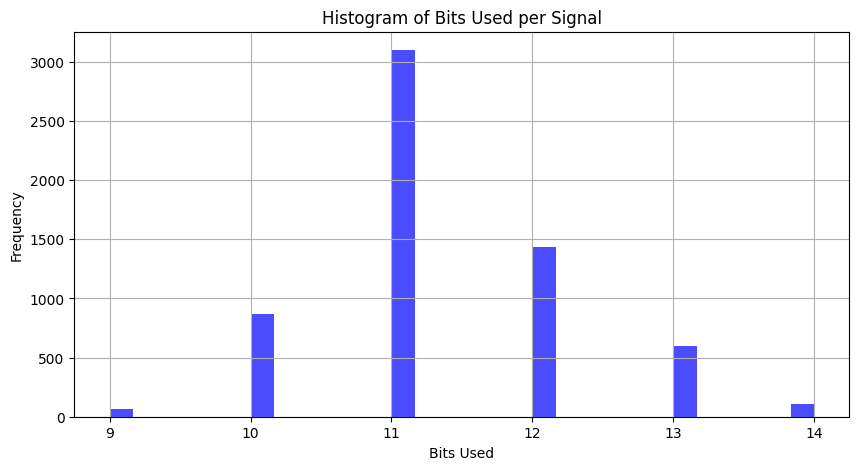

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(bits_used, bins=30, color="blue", alpha=0.7)
plt.title("Histogram of Bits Used per Signal")
plt.xlabel("Bits Used")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:

import zipfile
print(f"Size of original signals file: {train_data_path.stat().st_size} bytes")
with zipfile.ZipFile("original_train_data.zip", "w") as zipf:   # zip doesn't compress binary   
    zipf.write(train_data_path, arcname=train_data_path.name)
    
original_zip_size = Path("original_train_data.zip").stat().st_size
print(f"Size of original train data zip file: {original_zip_size} bytes")


encoded_file_size = Path("encoded_signals.bin").stat().st_size
print(f"Size of encoded signals file: {encoded_file_size} bytes")

with zipfile.ZipFile("encoded_signals.zip", "w") as zipf:
    zipf.write("encoded_signals.bin", arcname="encoded_signals.bin")
encoded_zip_size = Path("encoded_signals.zip").stat().st_size
print(f"Size of encoded signals zip file: {encoded_zip_size} bytes")
compression_ratio_zip = encoded_zip_size / original_zip_size
print(f"Compression ratio (zip): {compression_ratio_zip:.2f}")

Size of original signals file: 120641086 bytes
Size of original train data zip file: 120641206 bytes
Size of encoded signals file: 85590101 bytes
Size of encoded signals zip file: 85590237 bytes
Compression ratio (zip): 0.71
